In [388]:
import os
import random
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path

In [389]:
# !pip install tqdm

In [390]:
# TODO: 1. Привести изображение к чернобелому виду. 
# TODO: 2. Проверить помещается ли изображение в нейронную сеть. 
# TODO: 3. Разрезать изображение на кусочки и подавать его в нейронную сеть по частям. 
#       4. Научить склеивать изображения, после прохода через нейронную сеть. 

In [391]:
DATA_ROOT = '../pages/'

In [392]:
images_path = Path(DATA_ROOT+'source/')
annotation_path = Path(DATA_ROOT+'truth/')

In [393]:
# <DL_ZONE gedi_type="DLLogo"      id="None" col="92" row="167" width="755" height="228"> </DL_ZONE>
# <DL_ZONE gedi_type="DLSignature" id="None" col="821" row="1422" width="757" height="183" Overlapped="Yes" AuthorID="Koplow, M.G."> </DL_ZONE>

In [394]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [395]:
anno_dic = {'doc_name':'',
            'anno_path':'',
            'pages':'',
            # 'page_name':'',
            'page_id':'',
            'width':'',
            'height':'',
            'zone_type':'',
            # 'zone_id':'',
            'zone_col':'',
            'zone_row':'',
            'zone_width':'',
            'zone_height':'',
            # 'zone_Overlapped':'',
            # 'zone_AuthorID':''
        }

In [396]:
# Сохраним изображение. 

In [397]:
def generate_df(path):
    anno_list = []
    annotations = filelist(path, '.xml')
    ns = {'doc': "http://lamp.cfar.umd.edu/GEDI"}

    for anno_path in annotations:
        anno = {}
        root = ET.parse(anno_path).getroot()

        document  = root.find('doc:DL_DOCUMENT',ns)

        doc_attrib = document.attrib

        anno['doc_name'] = Path(str(images_path) + '/'+ doc_attrib['src'])
        anno['pages'] = doc_attrib['NrOfPages']
        #=================================================================#
        page = document.find('doc:DL_PAGE',ns)
        page_attrib = page.attrib
        # anno['page_name'] = Path(str(images_path) + '/'+ page_attrib['src'])
        anno['page_id'] = page_attrib['pageID']
        anno['width'] = int(page_attrib['width'])#.astype(np.int)
        anno['height'] = int(page_attrib['height'])#.astype(np.int)
        #=================================================================#

        zone = page.find('doc:DL_ZONE',ns)
        # anno['zone_type'] = ''
        if zone is not None:
            zone_attrib = zone.attrib

            anno['zone_type'] = zone_attrib['gedi_type']
            # anno['zone_id'] = zone_attrib['id']
            anno['zone_col'] = int(zone_attrib['col']) #.astype(np.int)
            anno['zone_row'] = int(zone_attrib['row']) #.astype(np.int)
            anno['zone_width'] = int(zone_attrib['width'])#.astype(np.int)
            anno['zone_height'] = int(zone_attrib['height'])#.astype(np.int)
            # if anno['zone_type'] == "DLSignature":
            #     anno['zone_Overlapped'] = zone_attrib['Overlapped']
            #     anno['zone_AuthorID'] = zone_attrib['AuthorID']
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [398]:
df = generate_df(annotation_path)
df

,doc_name,pages,page_id,width,height,zone_type,zone_col,zone_row,zone_width,zone_height
0,../pages/source/mcm24f00_2.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
1,../pages/source/nsr05f00_2.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
2,../pages/source/adh36e00-page2_2.tif,1,1,2560,3246,DLSignature,1232.0,2399.0,896.0,431.0
3,../pages/source/jon00a00.tif,1,1,2504,3111,DLSignature,1374.0,2478.0,668.0,304.0
4,../pages/source/byd23a00.tif,1,1,1728,2292,DLSignature,837.0,1014.0,302.0,135.0
...,...,...,...,...,...,...,...,...,...,...
995,../pages/source/mht90f00-var-full_1.tif,1,1,1200,1575,DLSignature,170.0,1049.0,394.0,65.0
996,../pages/source/qpb44c00-page03_1.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
997,../pages/source/hty24f00-page02_1.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
998,../pages/source/ahs60f00.tif,1,1,1200,1575,DLSignature,706.0,1110.0,202.0,52.0


In [399]:
df['zone_type'].value_counts()

DLSignature    595
DLLogo          65
Name: zone_type, dtype: int64

In [400]:
class_names = {'Void':0,'DLSignature':1,'DLLogo':2}

In [401]:
# Заполним пропуски. 
df.loc[(df['zone_type'].isnull()),'zone_type'] = 'Void'

# Приведем все классы к цыфровому виду.
df['zone_type'] = df['zone_type'].apply(lambda x: class_names[x])

In [402]:
df['zone_type'].value_counts() 

1    595
0    340
2     65
Name: zone_type, dtype: int64

In [403]:
# Изображений с логотипами очень мало.
# Есть большая вероятность, что на них нейронная сеть будет очень плохо обучаться.  

### Номер страницы будем извлекать из названия.

In [404]:
# df['zone_type'].isna().value_counts()

In [405]:
df.describe()

,width,height,zone_type,zone_col,zone_row,zone_width,zone_height
count,1000.000000,1000.000000,1000.000000,660.000000,660.000000,660.000000,660.000000
mean,2125.276000,2735.698000,0.725000,808.927273,1308.813636,434.856061,143.706061
std,585.006178,724.824685,0.574199,414.598628,698.596510,229.106523,77.788057
min,1200.000000,1575.000000,0.000000,29.000000,1.000000,69.000000,35.000000
25%,1728.000000,2292.000000,0.000000,561.000000,813.750000,264.000000,86.000000
50%,2544.000000,3258.000000,1.000000,715.000000,1211.500000,365.500000,124.500000
75%,2592.000000,3300.000000,1.000000,1150.500000,1852.500000,596.500000,181.000000
max,2720.000000,3584.000000,2.000000,1830.000000,3058.000000,1095.000000,579.000000


In [406]:
# Получить изображения.

In [407]:
len(class_names)

3

In [408]:
str(df['doc_name'][0])

'../pages/source/mcm24f00_2.tif'

In [409]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x, class_index):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols, _ = x.shape
    y_ind = np.zeros((rows, cols)) # Нужно больше каналов.
    y_cat = np.zeros((rows, cols , len(class_names)-1))
    bb = bb.astype(np.int)

    if class_index > 0:
        y_ind[bb[1]:bb[3]+bb[1],bb[0]: bb[2]+bb[0]] = class_index # У нас два класса. И, для каждого из них нужно сделать маску.
        y_cat[bb[1]:bb[3]+bb[1],bb[0]: bb[2]+bb[0], class_index-1] = 1
    return y_cat, y_ind

def create_bb_array(x,class_index):
    """Генерируем массив bounding box'a из столбца train_df"""
    if class_index == 0:
        res = np.array([0,0,0,0]) 
    else:
        res = np.array([x[0],x[1],x[2],x[3]])      
    return res

#========================================================================================
def mask_to_bb(y_cat):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    bbx = []
    for i in range(len(class_names)-1):
        cols, rows = np.nonzero(y_cat[..., i])
        if len(cols) == 0:
           bbx.append([0,0,0,0])
        else:
           top_row = np.min(rows)
           left_col = np.min(cols)
           bottom_row = np.max(rows)
           right_col = np.max(cols)
           bbx.append([top_row, left_col, bottom_row-top_row, right_col-left_col])
    return np.array(bbx, dtype=np.float32)
#========================================================================================
def resize_image_bb(img_size,img_new_size, bb):
    width, height =  img_size[0], img_size[1]
    new_width, new_height  = img_new_size[0], img_new_size[1]
    height_scale = new_height/height
    width_scale = new_width/width
    bb[0] *= width_scale 
    bb[1] *= height_scale
    bb[2] *= width_scale
    bb[3] *= height_scale
    return bb 

In [410]:
# # import seaborn as sns 
# def LayersToRGBImage(mask):
#     def resize_image_bb(read_path, write_path, bb, sz):
#     """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
#     im = read_image(read_path)
#     im_resized = cv2.resize(im, (sz, sz))
#     Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
#     new_path = str(write_path/read_path.parts[-1])
#     cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
#     return new_path, mask_to_bb(Y_resized)
#     nimg = np.zeros((mask.shape[0], mask.shape[1], 3))
#     for i in range(mask.shape[2]):# def resize_image_bb(read_path, write_path, bb, sz):
#     """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
#     im = read_image(read_path)
#     im_resized = cv2.resize(im, (sz, sz))
#     Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
#     new_path = str(write_path/read_path.parts[-1])
#     cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
#     return new_path, mask_to_bb(Y_resized)
#         c = mask[:,:,i]
#         color = classes_df.values[i][1:]
   
#         for j in range(3):
#             nimg[:,:,j]+=color[j]*c
#     nimg = nimg/255.0
#     return nimg

In [411]:
# def Color2index(y):
#     classes_df.values[0][1]
#     y_ind = np.zeros((y.shape[0], y.shape[1]))
#     y_cat = np.zeros((y.shape[0], y.shape[1], len(classes_df)))
#     i = 1
#     for ind in range(len(classes_df)):
#         ind_i = np.where(
#             (y[..., 0] == classes_df.iloc[ind][1]) 
#             & (y[..., 1] == classes_df.iloc[ind][2])
#             & (y[..., 2] == classes_df.iloc[ind][3])
#         )
#         y_ind[ind_i[0], ind_i[1]] = i
#         y_cat[ind_i[0], ind_i[1], i-1] = 1 
#         i += 1
    
#     return y_cat, y_ind #, i-1

In [412]:
# Откроем картинку
# img = cv2.imread(str(df['doc_name'][24])) # Нам не нужно цветное изображение. поэтому приведем все к одному каналу.

# plt.imshow(img)
# plt.show()

In [413]:
df.iloc[54].zone_type

1

In [414]:
def view_page(number):
    print(str(df['doc_name'][number]))
    im = cv2.imread(str(df.values[number][0]))
    class_index = df.iloc[number].zone_type
    
    bb = create_bb_array(df.values[number][6:], class_index)
    # print(im.shape)
    # print(bb)
    
    y_cat, y_ind = create_mask(bb, im, class_index)
    bbx = mask_to_bb(y_cat)
    # print(bbx)
    
    rect = plt.Rectangle((bb[0], bb[1]), bb[2], bb[3],fill=False, color='red')
    fig, ax = plt.subplots(1,2,figsize=(10,7))
    ax[0].imshow(im)
    ax[0].add_patch(rect)
    ax[1].imshow(y_ind)
    plt.show()

../pages/source/pxp81f00.tif


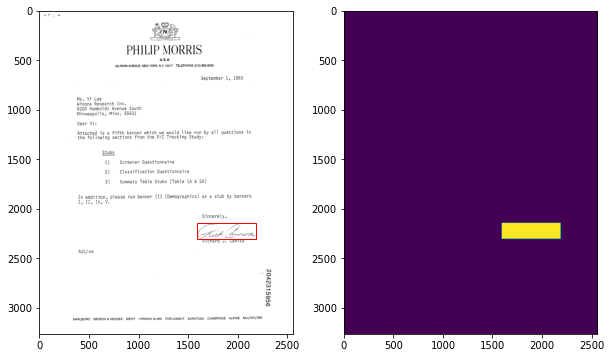

In [415]:
view_page(58)

../pages/source/cxk72e00-page03_1.tif


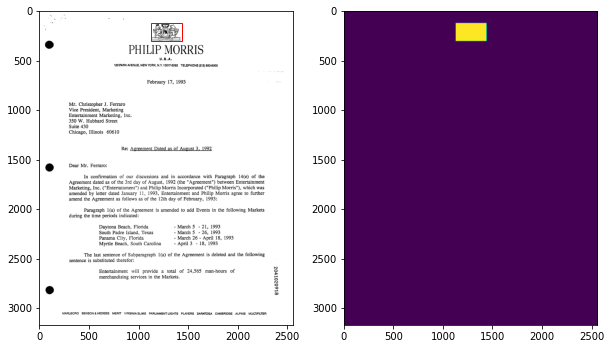

In [416]:
view_page(24)

../pages/source/jon00a00.tif


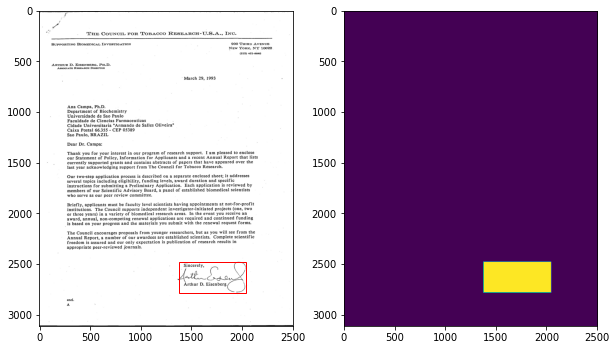

In [417]:
view_page(3)

In [418]:
# view_page(0)

In [419]:
# Попробуем изменить размер исходного изображения. 
# Это упростит процесс расплзнавания.

In [420]:
# Приведем все изображения к единому размеру.
# При обучении модели будем подавать изображения в сеть по частям.

# Т.к. лого и подписи врядли попадут в одни и теже квадраты, то будем отправлять 
# то будем применять самый простой алгоритм обучения. А, затем все склеим в вернем результаты.

In [421]:
# Составить таблицу для хранения координат объектов на изображении. 

In [422]:
# Отобразить извлеченные объекты на изображении.

Могут быть одинаковы изображения, Просто на одних размечены только подписи, ан на других логотоипы.

In [423]:
# os.makedirs(DATA_ROOT+'source_prepare', exist_ok=True)
# os.makedirs(DATA_ROOT+'mask_prepare', exist_ok=True)

In [424]:
# #  Откроем картинку.
img = cv2.imread(str(df['doc_name'][0])) # Нам не нужно цветное изображение. поэтому приведем все к одному каналу.

# plt.imshow(img)
# plt.show()

# img.shape
# img = cv2.resize(img,(1200,1600))
# plt.imshow(img)
# plt.show()

# df.values[58]

In [425]:
img.shape[0]

1575

In [426]:
# Откроем картинку.
# img = cv2.imread(str(df['doc_name'][24])) # Нам не нужно цветное изображение. поэтому приведем все к одному каналу.

# plt.imshow(img)
# plt.show()

# img.shape
# img = cv2.resize(img,(1200,1600))
# plt.imshow(img)
# plt.show()

# df.values[58]

In [427]:
IM_SIZE = (1200,1600)

In [428]:
new_image_paths = []
new_mask_paths = []
class_index = []
old_width = []
old_height = []
zone_col = []
zone_row = []
zone_width = []
zone_height = []

image_path_resized = Path(DATA_ROOT+'source_prepare')
Path.mkdir(image_path_resized, exist_ok=True)

mask_path_resized = Path(DATA_ROOT+'mask_prepare')
Path.mkdir(mask_path_resized, exist_ok=True)

for index, row in tqdm(df.iterrows()):
    try: 
        # if index >3:
        #         break
        im_path = Path(row['doc_name'])
        # Проверим. существуетли файл. 
        img = cv2.imread(str(im_path))

        img_height = img.shape[0]
        img_width = img.shape[1]

        im_resized = cv2.resize(img, IM_SIZE)
        new_image_path = str(image_path_resized/im_path.parts[-1])
        # print(new_image_path)
        cv2.imwrite(new_image_path, im_resized)
#=============================================================
        # im = cv2.imread(str(row.values[0]))
        curren_class = row['zone_type']
        bb = create_bb_array(row.values[6:], curren_class)

        # print(im.shape)
        # print(bb)
        y_cat, _ = create_mask(bb, img, curren_class)
        # img_width = row['width']
        # img_height = row['height']
        # curren_class = row['zone_type']
        bb_resized = resize_image_bb((img_width,img_height),IM_SIZE,bb)
        # название маски
#=============================================================
        # mask_path = Path(DATA_ROOT+'mask/'+row['mask'])
        # mask = cv2.im read(str(mask_path))
        
        # Сюда будем сохранять картинки. 
        # print((IM_SIZE[0], IM_SIZE[1], len(class_names)-1))
        # print(y_cat.shape)
        # mask_resized = np.resize(y_cat, (IM_SIZE[0], IM_SIZE[1], len(class_names)-1))

        # print(mask_resized.shape)

        # if curren_class > 0:
        #     bb_resized = mask_to_bb(mask_resized)
        #     print('bb: ',bb_resized)
        #     col, row, width, height = bb_resized[curren_class]
        # else:
        #     col,row, width, height = 0,0,0,0

        col,row, width, height = bb_resized
        # new_mask_path = str(mask_path_resized/im_path.stem)+'.png'
        # print(new_mask_path)
        # cv2.imwrite(new_mask_path, mask_resized)
        
        new_image_paths.append(new_image_path)
        # new_mask_paths.append(new_mask_path)
        old_height.append(img_height)
        old_width.append(img_width)
        class_index.append(curren_class)
        zone_col.append(col)
        zone_row.append(row)
        zone_width.append(width)
        zone_height.append(height)
        
    except Exception as ex:
        print(index, ex)
    
df_resize = pd.DataFrame({'doc_name':new_image_paths,
                          'old_width': old_width, 'old_height': old_height,
                          'zone_type': class_index, 
                          'zone_col': zone_col, 'zone_row':zone_row, 
                          'zone_width':zone_width, 'zone_height':zone_height})

1000it [01:27, 11.43it/s]


In [429]:
df_resize.head()

,doc_name,old_width,old_height,zone_type,zone_col,zone_row,zone_width,zone_height
0,../pages/source_prepare/mcm24f00_2.tif,1200,1575,0,0.000000,0.000000,0.000000,0.000000
1,../pages/source_prepare/nsr05f00_2.tif,1200,1575,0,0.000000,0.000000,0.000000,0.000000
2,../pages/source_prepare/adh36e00-page2_2.tif,2560,3246,1,577.500000,1182.501540,420.000000,212.446087
3,../pages/source_prepare/jon00a00.tif,2504,3111,1,658.466454,1274.445516,320.127796,156.348441
4,../pages/source_prepare/byd23a00.tif,1728,2292,1,581.250000,707.853403,209.722222,94.240838


In [432]:
def view_page_1(number):
    print(str(df_resize['doc_name'][number]))
    im = cv2.imread(str(df_resize.values[number][0]))
    class_index = df_resize.iloc[number].zone_type
    
    bb = create_bb_array(df_resize.values[number][4:], class_index)
    # print(im.shape)
    # print(bb)
    
    y_cat, y_ind = create_mask(bb, im, class_index)
    bbx = mask_to_bb(y_cat)
    # print(bbx)
    print()
    rect = plt.Rectangle((bb[0], bb[1]), bb[2], bb[3],fill=False, color='red')
    fig, ax = plt.subplots(1,2,figsize=(10,7))
    ax[0].imshow(im)
    ax[0].add_patch(rect)
    ax[1].imshow(y_ind)
    plt.show()

../pages/source_prepare/jon00a00.tif



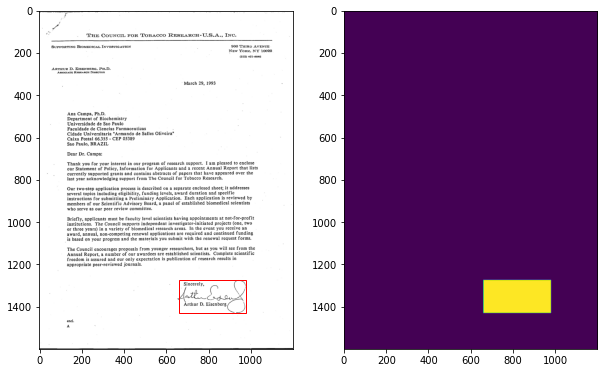

In [433]:
view_page_1(3)